# Regression: Predicting Social Media Addiction Scores

This notebook builds regression models to predict the **Addicted_Score** (continuous outcome) from user demographics, behavioral traits, and platform usage data. This complements the classification analysis by providing a continuous measure of addiction severity.

Key steps include:

- **Target Analysis**: Examining the distribution of `Addicted_Score` and applying transformations if needed
- **Feature Engineering**: Using the same preprocessing pipeline as classification
- **Baseline Model**: Using `DummyRegressor` to establish performance floor
- **Linear Regression**: Traditional interpretable approach
- **CatBoost Regressor**: Advanced gradient boosting for improved performance
- **Model Evaluation**: MAE, RMSE, R² metrics with residual analysis
- **Feature Profiling**: SHAP explainability for understanding feature contributions
- **MLflow Integration**: Comprehensive experiment tracking and model management

This notebook aims to build accurate, explainable regression models while maintaining reproducibility through structured logging and experimentation.


# Environment Setup & Dependencies

This section establishes the computational environment and imports essential libraries organized by functionality for optimal performance and maintainability.


In [ ]:
# --- IPython/Jupyter Extensions ---
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import os
import pickle
import sys
import warnings

# --- Data Science Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- ML & Preprocessing ---
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    # PowerTransformer
)
from sklearn.base import clone
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Advanced ML Libraries ---
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
# import shap

# --- MLflow & Experiment Tracking ---
import mlflow
import mlflow.data
import mlflow.sklearn
from mlflow.data.pandas_dataset import PandasDataset
from mlflow.models.signature import infer_signature

# --- Utilities & Custom Modules ---
from scipy import sparse, stats
sys.path.append('../src')
from utils import (    
    country_to_continent,
    RareCategoryGrouper,
    CountryToContinentMapper,
    get_feature_names,
    # mlflow_dataset,
    # run_shap_experiment
)
from regression import (
    # run_regression_experiment,
    # log_regression_test_performance,
    # create_residual_plots,
    # create_prediction_plots,
    check_target_distribution,
    run_regression_gridsearch_experiment,
    RoundingRegressor
)

# --- Environment & Config ---
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
# import dagshub
load_dotenv()

DAGSHUB_USER_NAME = os.getenv("DAGSHUB_USER_NAME")
DAGSHUB_REPO = os.getenv("DAGSHUB_REPO")
DAGSHUB_TOKEN = os.getenv("DAGSHUB_TOKEN")
os.environ["MLFLOW_TRACKING_PASSWORD"] = DAGSHUB_TOKEN


/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parameters


In [2]:
dagshub_tracking = False
random_state = 42
np.random.seed(random_state)


# MLflow Setup

This section configures MLflow for experiment tracking and model management, ensuring reproducibility and efficient collaboration.

- **Tracking URI:** Set to a local directory to store experiment data and artifacts.
- **Experiment Management:** Initializes or retrieves the experiment named "Regression_Addiction_Score" for organized tracking of model runs and results.


In [3]:
from utils import quick_delete_experiment

# Set MLflow tracking URI
if dagshub_tracking:
    import dagshub    
    dagshub.init(repo_owner=DAGSHUB_USER_NAME, repo_name=DAGSHUB_REPO, mlflow=True)
    print("Dagshub tracking enabled")
else:
    mlflow.set_tracking_uri("file:../mlruns")
    print("Local tracking enabled")

# Create or get experiment
experiment_name = "Regression_Addiction_Score"
mlflow.set_experiment(experiment_name)

quick_delete_experiment(experiment_name)


Local tracking enabled
Deleted 14 runs from 'Regression_Addiction_Score'


# Loading Cleaned Data

This section involves loading the pre-processed dataset for regression analysis. The target variable is `Addicted_Score`, a continuous measure of social media addiction severity.

- **Data Source:** The cleaned dataset is stored in a serialized format (`data_cleaned.pickle`) for efficient loading and processing.
- **Target Variable:** `Addicted_Score` - continuous variable representing addiction level
- **Initial Exploration:** Basic dataset statistics and target variable distribution analysis


In [4]:
# Load cleaned data
with open('../data/data_cleaned.pickle', 'rb') as f:
    df_data = pickle.load(f)

# Display basic information
print("Dataset shape:", df_data.shape)
print("\nTarget variable (Addicted_Score) statistics:")
print(df_data['Addicted_Score'].describe())
df_data.head()


Dataset shape: (702, 13)

Target variable (Addicted_Score) statistics:
count    702.000000
mean       6.435897
std        1.575768
min        3.000000
25%        5.000000
50%        7.000000
75%        8.000000
max        9.000000
Name: Addicted_Score, dtype: float64


,Student_ID,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


# Target Variable Analysis

Comprehensive analysis of the target variable distribution `Addicted_Score` to understand its characteristics and determine if any transformations are needed for better model performance.

### Findings:

1. **Skewness and Histogram**:
   - The original distribution has a slight negative skew (\(-0.283\)), indicating a longer left tail. 
   - The histogram shows a relatively symmetric distribution with a few more extreme low values.

2. **Kurtosis**:
   - The kurtosis value (\(-0.936\)) suggests a platykurtic distribution, meaning the distribution has lighter tails and a flatter peak compared to a normal distribution.

3. **Q-Q Plot**:
   - The Q-Q plot shows that the data points generally follow the red line, indicating that the data is approximately normally distributed.
   - There are slight deviations at the tails, suggesting some departure from normality, but overall, the fit is reasonable.

4. **Log Transformation**:
   - The log-transformed distribution shows increased negative skewness (\(-0.631\)), which may help in normalizing the data for certain analyses.

Overall, the `Addicted_Score` is approximately normal, with minor deviations. The log transformation increases skewness, which might be useful for specific modeling techniques.

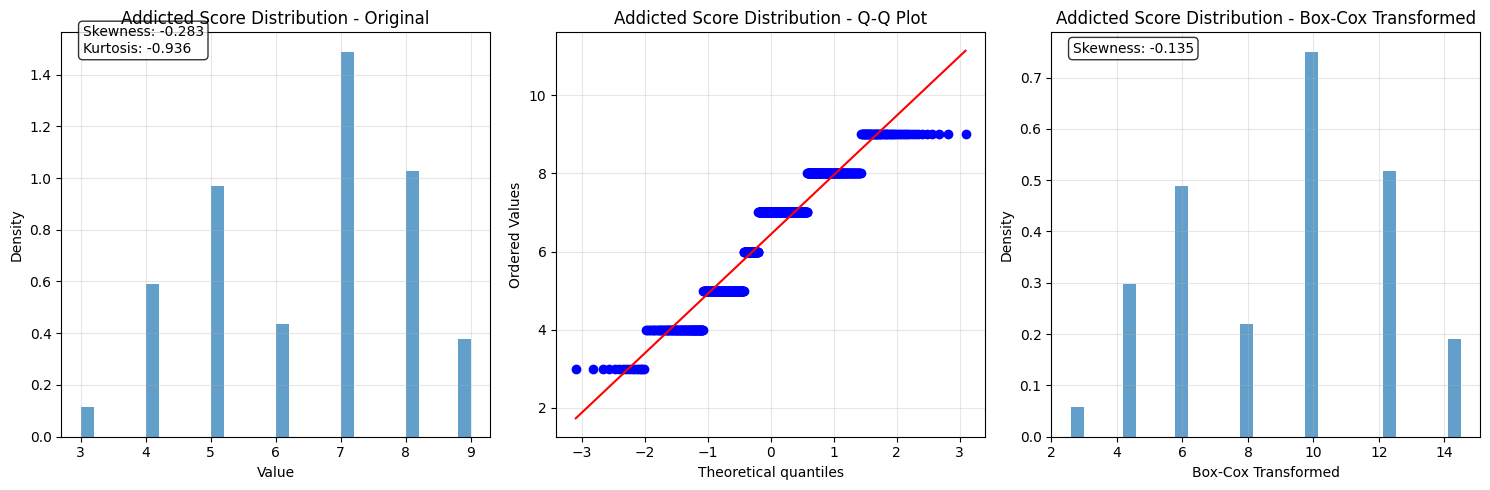

Target Variable Statistics:
skewness: -0.2825
kurtosis: -0.9364
mean: 6.4359
std: 1.5746
min: 3.0000
max: 9.0000
skewness_boxcox: -0.1353


In [5]:
# Analyze target variable distribution
target_stats = check_target_distribution(
    df_data['Addicted_Score'], 
    title="Addicted Score Distribution",
    transform="boxcox"
)

print("Target Variable Statistics:")
for key, value in target_stats.items():
    print(f"{key}: {value:.4f}")


# Data Splitting

As a crucial step for model validation and performance assessment, we divide the dataset into training and testing subsets.

- **Purpose:** The training set is used to fit the model, while the test set evaluates its predictive performance on unseen data.
- **Methodology:** Utilizes an 80/20 split to ensure a robust evaluation framework.
- **Random State:** A fixed random state (42) is used to ensure reproducibility of the split.


In [6]:
# Split the data into train and test
from sklearn.model_selection import train_test_split

# Drop unnecessary columns - we're predicting Addicted_Score
drop_cols = ['Student_ID', 'Conflicts', 'Addicted_Score']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_data.drop(columns=drop_cols), 
    df_data['Addicted_Score'], 
    test_size=0.2, 
    random_state=random_state
)

# Print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target range - Train: {y_train_full.min():.2f} to {y_train_full.max():.2f}")
print(f"Target range - Test: {y_test.min():.2f} to {y_test.max():.2f}")

X_train_full.head()


Train set shape: (561, 10)
Test set shape: (141, 10)
Target range - Train: 3.00 to 9.00
Target range - Test: 3.00 to 9.00


,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status
166,20,Female,Undergraduate,Bangladesh,4.9,Instagram,Yes,6.4,5,Single
546,20,Female,Undergraduate,UAE,6.9,Instagram,Yes,6.1,5,In Relationship
285,21,Male,Graduate,UK,5.0,Facebook,Yes,6.6,6,In Relationship
362,20,Female,Undergraduate,Ireland,4.5,TikTok,Yes,7.4,7,Single
111,21,Female,Undergraduate,India,5.8,TikTok,Yes,5.9,6,In Relationship


# Preprocessing Pipeline

This section outlines the preprocessing steps applied to the dataset to prepare it for regression model training. The pipeline uses the same feature engineering approach as the classification task.

- **Feature Engineering:** Converts categorical features into numerical representations
  - **Binary Encoding:** Transforms binary categorical variables into 0/1 format
  - **One-Hot Encoding:** Applies to low and high cardinality categorical features
  - **Rare Category Grouping:** Groups infrequent categories to reduce dimensionality
  - **Geographical Mapping:** Maps countries to continents for regional analysis

- **Numerical Scaling:** Standardizes numerical features for regression models

This preprocessing pipeline ensures consistent input for all regression models.


In [7]:
# Define Column Groups
binary_cats       = ['Gender']         # boolean → 0/1
low_card_cols     = ['Relationship_Status', 'Academic_Level']  # few categories
high_card_cols    = ['Platform']       # group rare then OHE
country_col       = ['Country']        # map to continent
numeric_cols      = X_train_full.select_dtypes(include=['number']).columns

print(f"Binary categorical columns: {binary_cats}")
print(f"Low cardinality columns: {low_card_cols}")
print(f"High cardinality columns: {high_card_cols}")
print(f"Country column: {country_col}")
print(f"Numeric columns: {list(numeric_cols)}")


Binary categorical columns: ['Gender']
Low cardinality columns: ['Relationship_Status', 'Academic_Level']
High cardinality columns: ['Platform']
Country column: ['Country']
Numeric columns: ['Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health']


In [8]:
# Define preprocessing steps
# Boolean → int
binary_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Low-cardinality One-Hot
low_card_transformer = OneHotEncoder(handle_unknown='ignore')

# High-cardinality grouping + One-Hot
high_card_transformer = Pipeline([
    ('group_rare', RareCategoryGrouper(min_count=30)),
    ('onehot',    OneHotEncoder(handle_unknown='ignore'))
])

# Country → Continent → One-Hot
country_transformer = Pipeline([
    ('map_continent', CountryToContinentMapper(mapping=country_to_continent)),
    ('onehot',        OneHotEncoder(handle_unknown='ignore'))
])

# Numeric scaling
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('bools',   binary_transformer,   binary_cats),
    ('low_ohe', low_card_transformer, low_card_cols),
    ('high_ohe',high_card_transformer,high_card_cols),
    ('cty_ohe', country_transformer,  country_col),
    ('nums',    numeric_transformer,  numeric_cols),
], remainder='drop')


Transformed feature matrix (first 5 rows):
   Gender_Male  Relationship_Status_Complicated  \
0          0.0                              0.0   
1          0.0                              0.0   
2          1.0                              0.0   
3          0.0                              0.0   
4          0.0                              0.0   

   Relationship_Status_In Relationship  Relationship_Status_Single  \
0                                  0.0                         1.0   
1                                  1.0                         0.0   
2                                  1.0                         0.0   
3                                  0.0                         1.0   
4                                  1.0                         0.0   

   Academic_Level_Graduate  Academic_Level_High School  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      1.0                         0.0 

<Figure size 1500x1000 with 0 Axes>

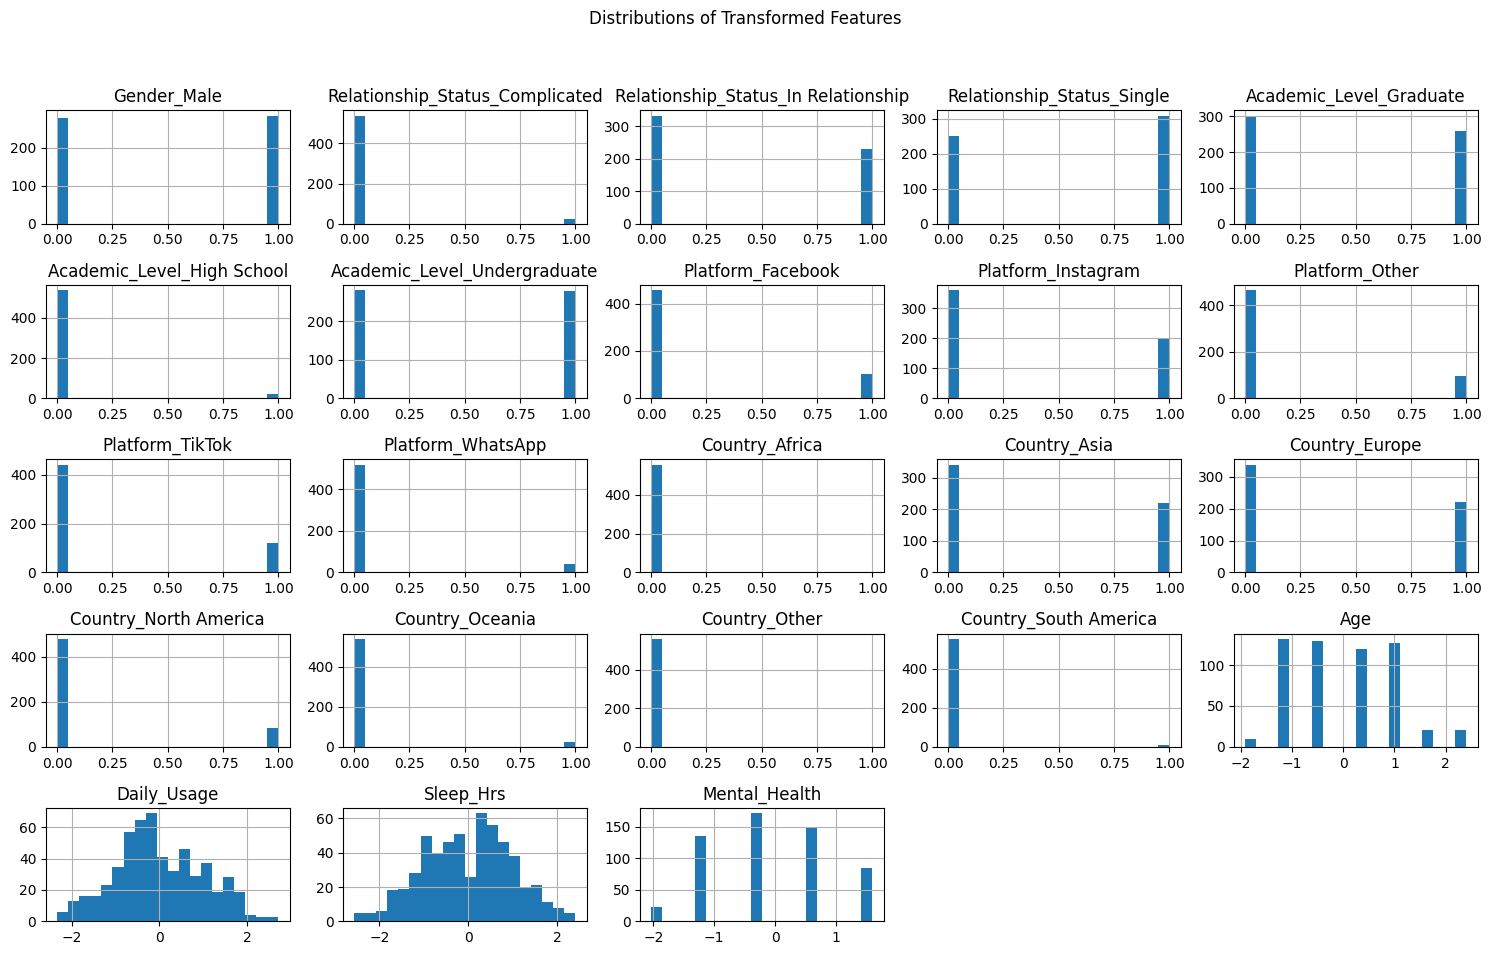

In [9]:
# Apply preprocessing and inspect transformed features
# 1. Fit the preprocessing step on the training data
preprocessor.fit(X_train_full)

# 2. Transform the training data
X_train_proc = preprocessor.transform(X_train_full)

# 3. Retrieve the transformed feature names
feature_names = get_feature_names(preprocessor)

# 4. Convert to DataFrame (densify if sparse)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()

X_train_df = pd.DataFrame(X_train_proc, columns=feature_names)

# 5. Print the first few rows
print("Transformed feature matrix (first 5 rows):")
print(X_train_df.head())
print(f"\nTotal features after preprocessing: {len(feature_names)}")

# 6. Simple visualization: histograms for each feature
plt.figure(figsize=(15, 10))
X_train_df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distributions of Transformed Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Dataset Preparation for MLflow

This section prepares dataset objects for MLflow logging, facilitating model reproducibility and experiment tracking.


In [10]:
# Create MLflow dataset objects
train_ds = mlflow.data.from_pandas(
    df=X_train_full,
    source="../data/data_cleaned.pickle",
    name="social_sphere_regression_train_v1"
)
test_ds = mlflow.data.from_pandas(
    df=X_test,
    source="../data/data_cleaned.pickle",
    name="social_sphere_regression_test_v1"
)

# Create dataset dictionary for utility functions
dataset = {
    "train_ds": train_ds,
    "test_ds": test_ds
}

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

# Define scoring metrics for regression
scoring = {
    "r2": "r2",
    "MAE": "neg_mean_absolute_error",
    "MSE": "neg_mean_squared_error",
    "RMSE": "neg_root_mean_squared_error",
    'MAPE': 'neg_mean_absolute_percentage_error'
}


# Baseline Model: DummyRegressor

The `DummyRegressor` is used to establish a performance baseline, setting the minimum acceptable performance threshold for more sophisticated models.

## Best Parameter
- **Mean**

## Results
- **R²**: 0
- **MAE**: 1.38
- **MAPE**: 25%

In [11]:
# Create baseline dummy regressor pipeline
run_tag = "all_features"
run_name = f"baseline_{run_tag}"

dummy_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])

param_grid_dummy = {
    'regressor__strategy': ['mean', 'median', 'quantile', 'constant']
}

# Run dummy regressor gridsearch experiment
best_baseline_dummy, test_results, *figures = run_regression_gridsearch_experiment(
    name=run_name,
    pipeline=dummy_pipeline,
    param_grid=param_grid_dummy,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=dataset,
    registered_model_name="addicted_score_baseline",
    verbose=True,
    run_tag=run_tag,
    refit_metric="r2"
)

# print("\nBest parameters found:")
# print(best_dummy.best_params_)
# print(f"\nBest CV R² score: {best_dummy.best_score_:.4f}")

print("Baseline dummy regressor experiment completed!")

# Initialint performance dataframe
columns = test_results.keys()
columns = [c for c in columns if c != 'predictions']
# columns
df_performance = pd.DataFrame({k: v for k, v in test_results.items() if k != 'predictions'}, index=[run_name])
df_performance


Fitting 5 folds for each of 4 candidates, totalling 20 fits
r2: -0.0 ± 0.0
MAE: -1.38 ± 0.02
MSE: -2.49 ± 0.09
RMSE: -1.58 ± 0.03
MAPE: -0.25 ± 0.0
Model type: other
Best parameters: {'regressor__strategy': 'mean'}
Best R² score (CV): -0.0
Baseline dummy regressor experiment completed!


Registered model 'addicted_score_baseline' already exists. Creating a new version of this model...
Created version '17' of model 'addicted_score_baseline'.


,mae,mse,rmse,r2,mape
baseline_all_features,1.339275,2.440805,1.562308,-0.010025,0.235844


# Linear Regression Model

The traditional linear regression model is utilized for interpretable addiction score prediction. This model provides coefficients that clearly illustrate the relationship between features and addiction levels.

## Results
- **R²**: 0.93
- **MAE**: 0.32
- **MSE**: 0.17
- **MAPE**: 0.05

## Observations
- The **R²** value is significantly better than the baseline, indicating a strong fit.
- The **MAPE** has decreased considerably, reflecting improved prediction accuracy.
- The model's coefficients are non-zero, with the largest values associated with mental health, TikTok usage, other platforms, and daily usage.
- SHAP analysis highlights mental health as the most influential feature in the model's predictions.

Fitting 5 folds for each of 4 candidates, totalling 20 fits
r2: 0.93 ± 0.01
MAE: -0.32 ± 0.03
MSE: -0.17 ± 0.03
RMSE: -0.41 ± 0.03
MAPE: -0.05 ± 0.01
Model type: linear
Model name: LinearRegression
Best parameters: {'regressor__copy_X': True, 'regressor__fit_intercept': True}
Best R² score (CV): 0.93
Linear regression experiment completed!


Registered model 'addicted_score_linear_all_features' already exists. Creating a new version of this model...
Created version '15' of model 'addicted_score_linear_all_features'.


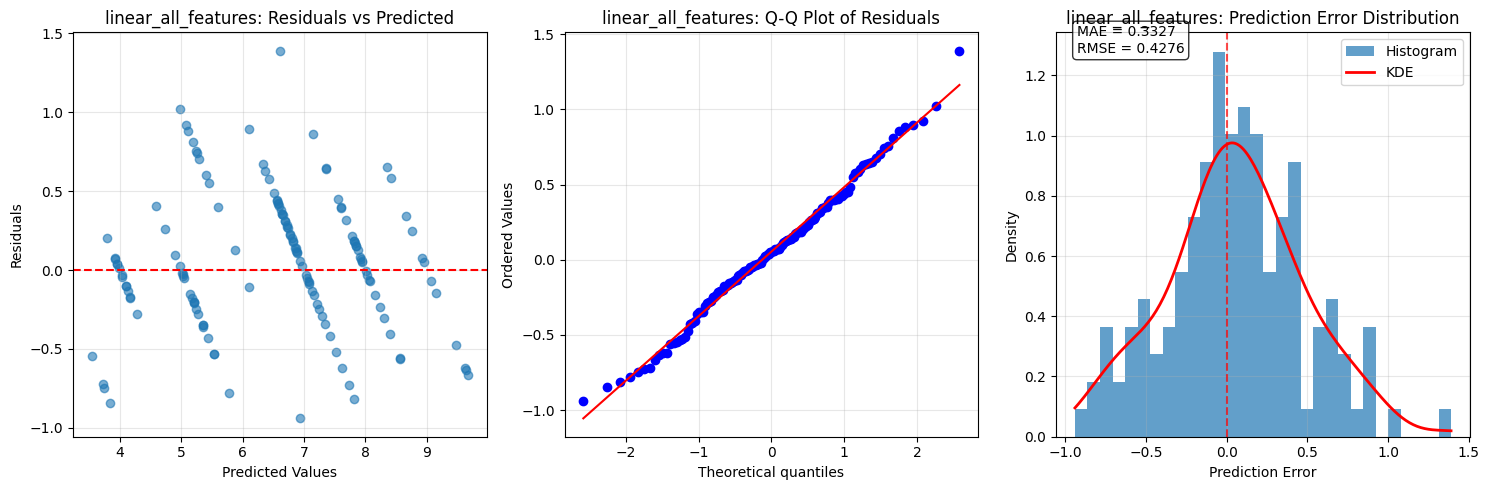

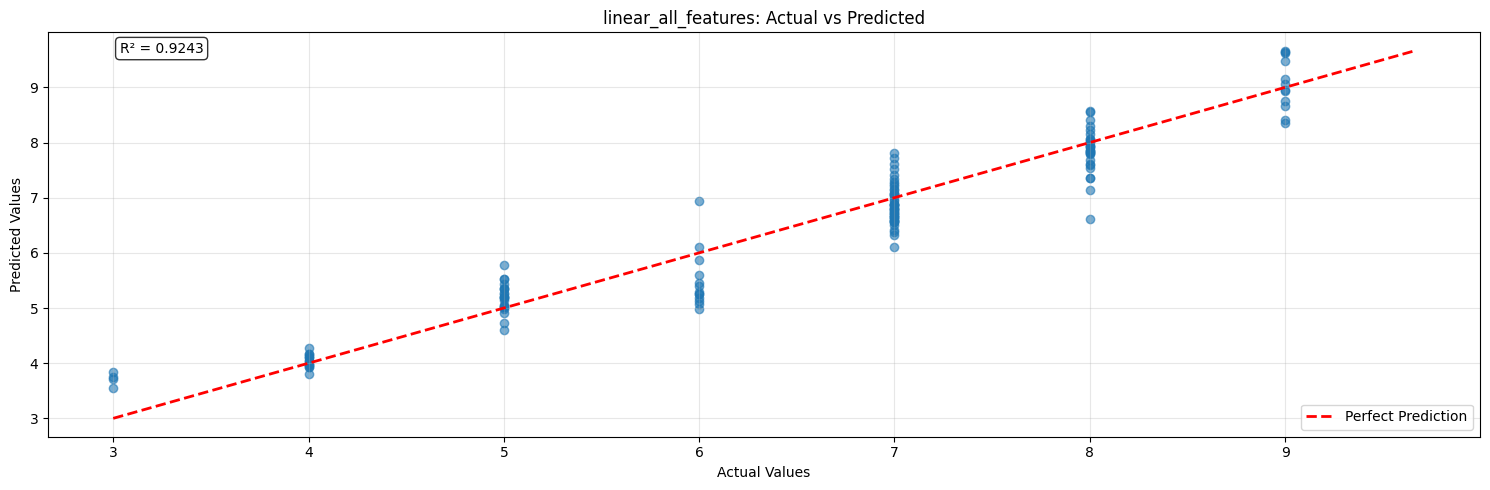

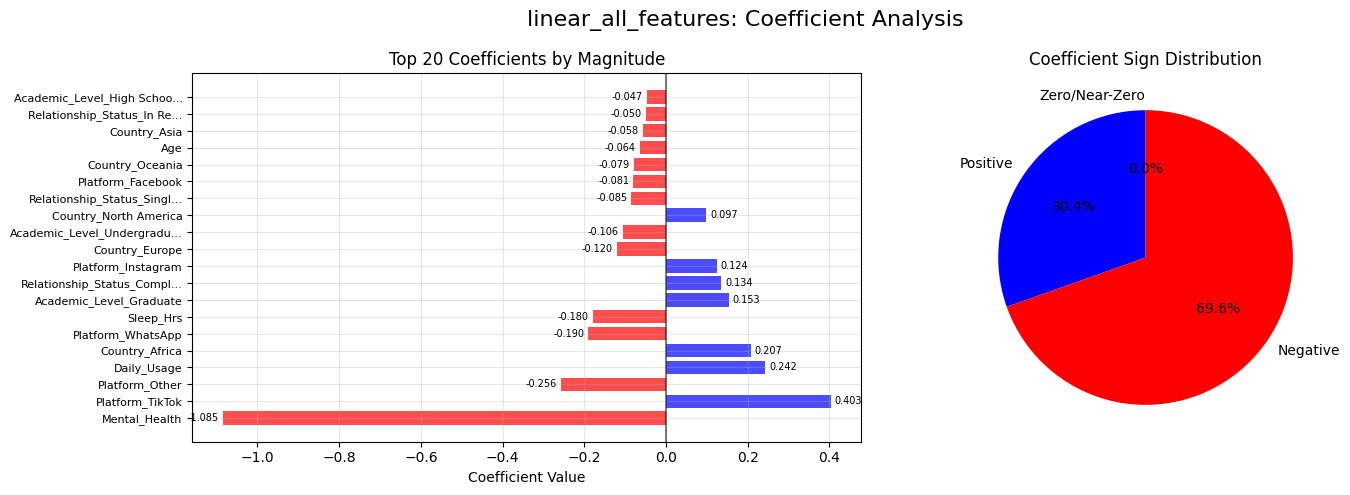

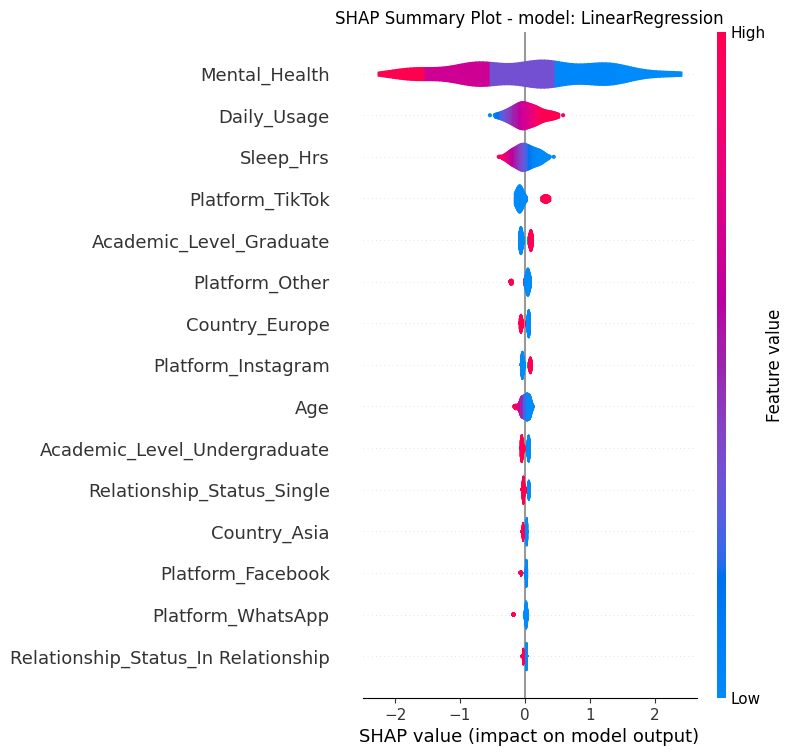

,mae,mse,rmse,r2,mape
baseline_all_features,1.339275,2.440805,1.562308,-0.010025,0.235844
linear_all_features,0.332732,0.182879,0.427643,0.924323,0.054121


In [12]:
run_tag = "all_features"
run_name = f"linear_{run_tag}"

# Create linear regression pipeline
linear_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

param_grid_linear = {
    'regressor__fit_intercept': [True, False],
    'regressor__copy_X': [True, False]
}

# Run linear regression experiment
best_linear, test_results, *figures_linear = run_regression_gridsearch_experiment(
    name=run_name,
    pipeline=linear_pipeline,
    param_grid=param_grid_linear,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=dataset,
    registered_model_name=f"addicted_score_linear_{run_tag}",
    verbose=True,
    run_tag=run_tag,
    refit_metric="r2",
    # round_output = True,
    linear = True
)

print("Linear regression experiment completed!")

for fig in figures_linear:    
    display(fig)

# ===== Log results
# Append new row to existing dataframe instead of creating new one
df_performance.loc[run_name] = {k: v for k, v in test_results.items() if k != 'predictions'}
df_performance

# df_performance.to_csv(f"../data/performance_{run_name}.csv", index=False)

# Rounding Predictions: Integer Output Models

In practical applications, it is often beneficial to have predictions as integers within a valid range (3-9), as addiction scores are typically discrete values. To achieve this, we implement a wrapper that rounds predictions and applies bounds.

## Results
- **R²**: 0.91 
- **RMSE**: 0.48
- **MAPE**: 0.04

## Observations
- The model outputs integer predictions, which can influence error metrics.

In [13]:
run_tag = "all_features+rounded"
run_name = f"linear_{run_tag}"

# Create linear regression pipeline with rounding
linear_pipeline_rounded = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RoundingRegressor(
        regressor=LinearRegression(),
        min_value=3, 
        max_value=9
    ))
])


param_grid_linear_rounded = { f'regressor__{k}': v for k, v in param_grid_linear.items()}

# Run linear regression experiment with rounding
best_linear_rounded, test_results, *figures_linear_rounded = run_regression_gridsearch_experiment(
    name=run_name,
    pipeline=linear_pipeline_rounded,
    param_grid=param_grid_linear_rounded,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=dataset,
    registered_model_name=f"addicted_score_linear_{run_tag}",
    verbose=True,
    run_tag=run_tag,
    refit_metric="r2",
    linear=True,
    # shap=False
)

print("Linear regression experiment with rounded predictions completed!")

# for fig in figures_linear_rounded:    
    # display(fig)

# ===== Log results
# Append new row to existing dataframe instead of creating new one
df_performance.loc[run_name] = {k: v for k, v in test_results.items() if k != 'predictions'}
df_performance

Fitting 5 folds for each of 4 candidates, totalling 20 fits
r2: 0.91 ± 0.02
MAE: -0.23 ± 0.04
MSE: -0.23 ± 0.04
RMSE: -0.48 ± 0.04
MAPE: -0.04 ± 0.01
Model type: linear
Model name: LinearRegression
Best parameters: {'regressor__regressor__copy_X': True, 'regressor__regressor__fit_intercept': True}
Best R² score (CV): 0.91
Linear regression experiment with rounded predictions completed!


Registered model 'addicted_score_linear_all_features+rounded' already exists. Creating a new version of this model...
Created version '13' of model 'addicted_score_linear_all_features+rounded'.


,mae,mse,rmse,r2,mape
baseline_all_features,1.339275,2.440805,1.562308,-0.010025,0.235844
linear_all_features,0.332732,0.182879,0.427643,0.924323,0.054121
linear_all_features+rounded,0.234043,0.234043,0.483779,0.903151,0.040532


# Removing the Mental Health Feature

We exclude the mental health variable as it is a self-reported feature that may introduce bias regarding students' addiction scores, potentially inflating model performance artificially.

## Results
- **R²**: 0.76
- **RMSE**: 0.76
- **MAPE**: 0.09

## Observations
- The decrease in **R²** and increase in error metrics is expected, as we removed a feature highly correlated with the target variable.
- Without mental health, the model primarily relies on **daily usage** and **sleep hours** as key predictive features.
- All coefficients remain non-zero, with an equal split between positive and negative relationships.
- This approach provides a more objective model by avoiding potentially biased self-reported mental health assessments.

Fitting 5 folds for each of 4 candidates, totalling 20 fits
r2: 0.76 ± 0.04
MAE: -0.51 ± 0.08
MSE: -0.58 ± 0.1
RMSE: -0.76 ± 0.07
MAPE: -0.09 ± 0.01
Model type: linear
Model name: LinearRegression
Best parameters: {'regressor__regressor__copy_X': True, 'regressor__regressor__fit_intercept': True}
Best R² score (CV): 0.76
Linear regression experiment without Mental Health completed!


Registered model 'addicted_score_linear_no_mh+rounded' already exists. Creating a new version of this model...
Created version '11' of model 'addicted_score_linear_no_mh+rounded'.


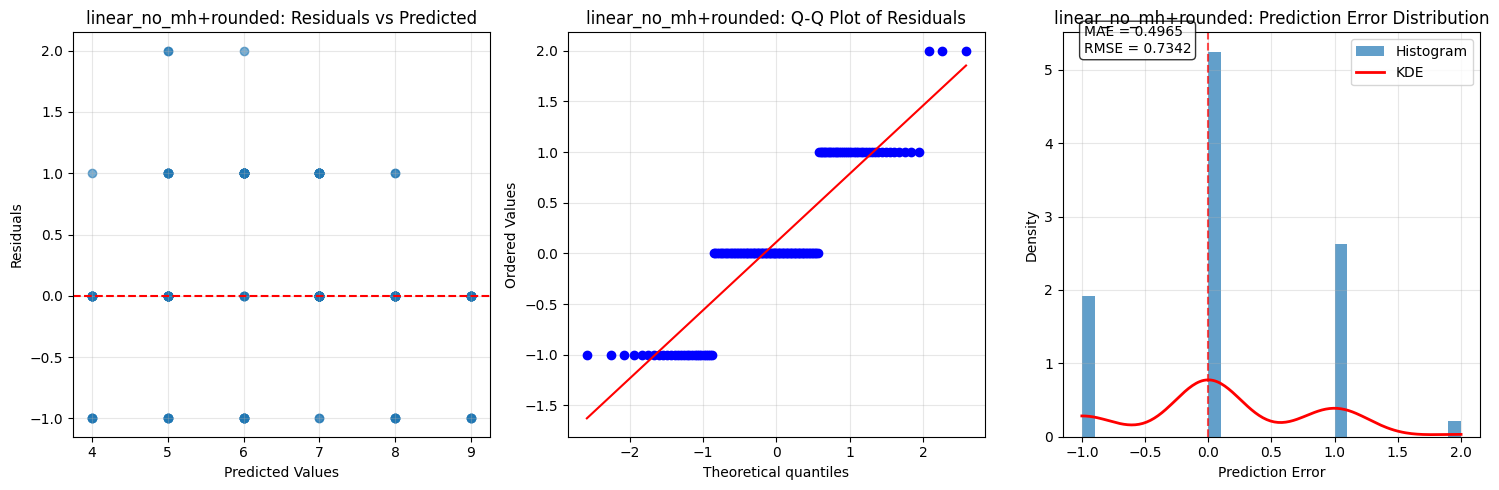

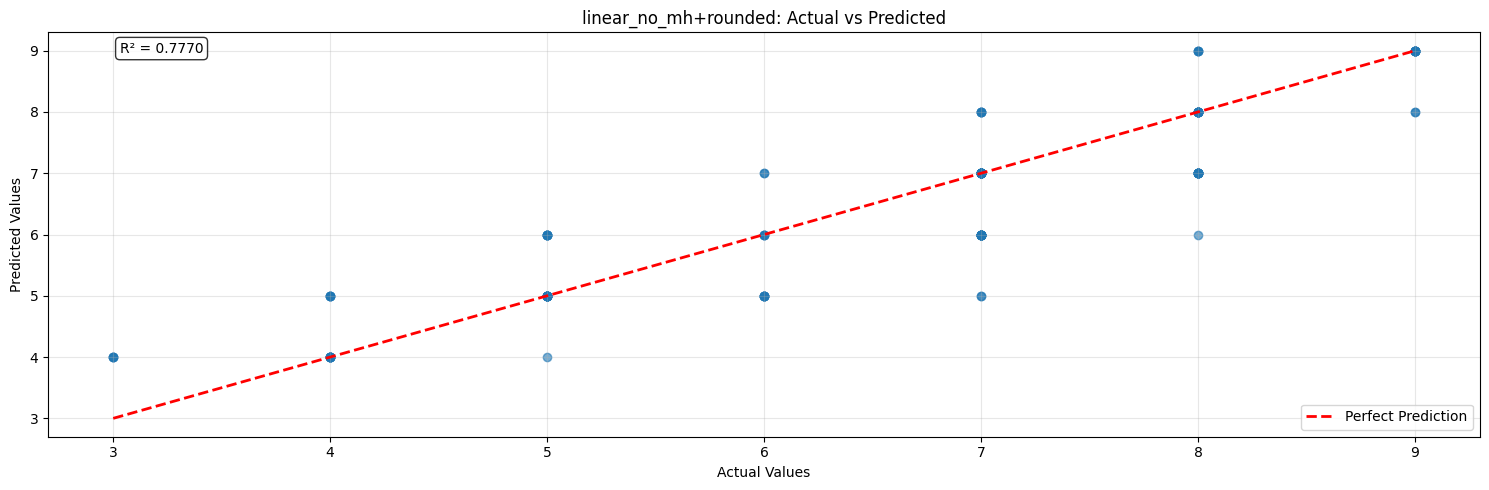

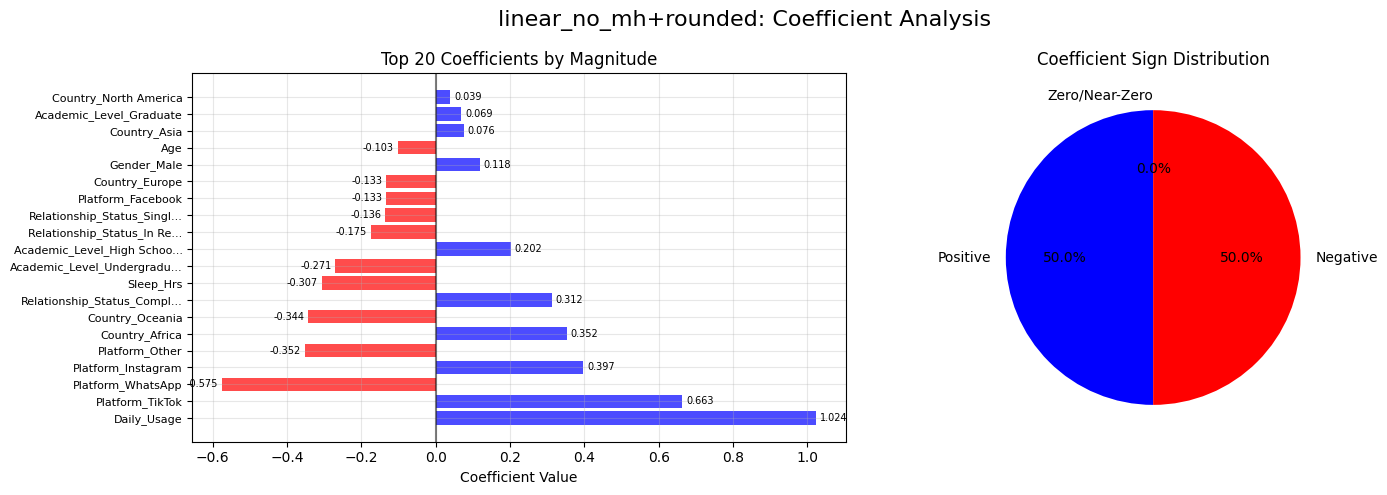

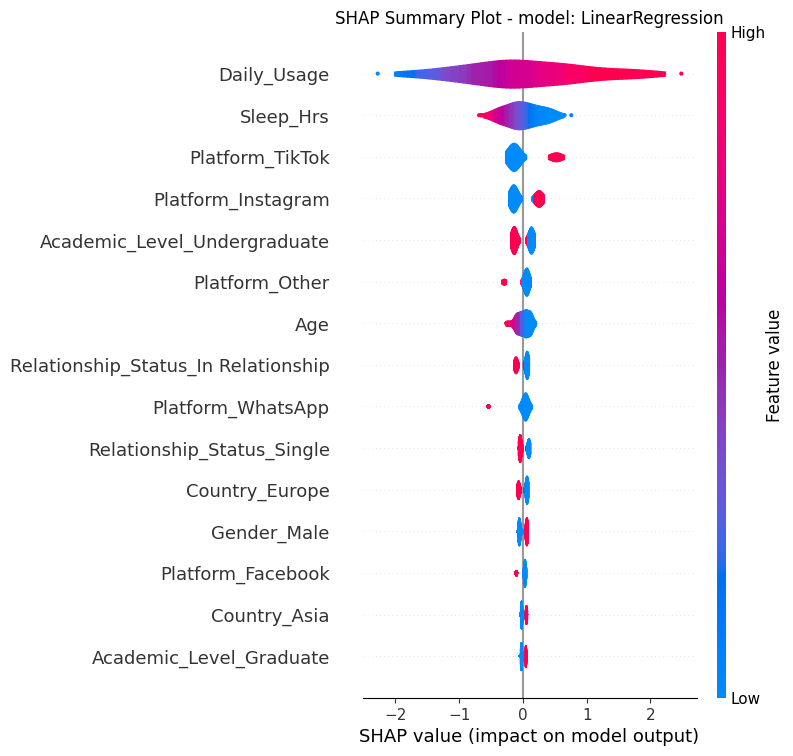

,mae,mse,rmse,r2,mape
baseline_all_features,1.339275,2.440805,1.562308,-0.010025,0.235844
linear_all_features,0.332732,0.182879,0.427643,0.924323,0.054121
linear_all_features+rounded,0.234043,0.234043,0.483779,0.903151,0.040532
linear_no_mh+rounded,0.496454,0.539007,0.734171,0.776954,0.082157


In [14]:
run_tag="no_mh+rounded"
run_name = f"linear_{run_tag}"

numeric_cols_no_mh = [c for c in numeric_cols if c != 'Mental_Health']
linear_pipeline_no_mh = clone(linear_pipeline_rounded)
preprocessor_no_mh = linear_pipeline_no_mh.named_steps['preprocessing']
preprocessor_no_mh.transformers[4] = (
    'nums', numeric_transformer, numeric_cols_no_mh
)
linear_pipeline_no_mh.named_steps['preprocessing'] = preprocessor_no_mh


# Run linear regression experiment
best_linear_no_mh, test_results, *figures_linear_no_mh = run_regression_gridsearch_experiment(
    name=run_name,
    pipeline=linear_pipeline_no_mh,
    param_grid=param_grid_linear_rounded,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=dataset,
    registered_model_name=f"addicted_score_linear_{run_tag}",
    verbose=True,
    run_tag=run_tag,
    refit_metric="r2",
    linear=True,
    # shap=False
)

print("Linear regression experiment without Mental Health completed!")

for fig in figures_linear_no_mh:    
    display(fig)

# ===== Log results
# Append new row to existing dataframe instead of creating new one
df_performance.loc[run_name] = {k: v for k, v in test_results.items() if k != 'predictions'}
df_performance

# Lasso Regression

Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression technique that performs both variable selection and regularization. It helps enhance the prediction accuracy and interpretability of the model by:

- **Feature Selection**: Lasso automatically selects the most important features by shrinking less important ones to zero.
- **Handling Multicollinearity**: It effectively manages correlated predictors by choosing among them.
- **Preventing Overfitting**: Regularization reduces model complexity, improving generalization to new data.


## Results
- **R²**: 0.76
- **RMSE**: 0.76
- **MAPE**: 0.09

## Observations
- **Feature Coefficients**: 27% of feature coefficients are zeroed, indicating effective feature selection.
- **SHAP Analysis**: Highlights the high importance of daily usage, TikTok usage, and sleep hours in predicting addiction scores.
- **Lasso Important Features**: Daily usage and TikTok usage are identified as key predictors, aligning with SHAP findings.
- **Comparison with Previous Models**:
  - The **R²** value is similar to the model without the mental health feature, suggesting comparable predictive power.
  - Error metrics (MAE, MSE, RMSE, MAPE) are slightly higher than the linear regression model, reflecting the trade-off between model complexity and generalization.
  - Lasso's ability to zero out coefficients helps in simplifying the model, potentially leading to better interpretability and reduced overfitting.

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
r2: 0.92 ± 0.01
MAE: -0.21 ± 0.03
MSE: -0.21 ± 0.03
RMSE: -0.46 ± 0.04
MAPE: -0.04 ± 0.01
Model type: linear
Model name: Lasso


Registered model 'addicted_score_lasso_all_features+rounded' already exists. Creating a new version of this model...
Created version '5' of model 'addicted_score_lasso_all_features+rounded'.


Best parameters: {'regressor__regressor__alpha': 0.01, 'regressor__regressor__fit_intercept': True, 'regressor__regressor__max_iter': 1000, 'regressor__regressor__selection': 'random', 'regressor__regressor__tol': 0.001}
Best R² score (CV): 0.92
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
r2: 0.76 ± 0.04
MAE: -0.51 ± 0.08
MSE: -0.58 ± 0.1
RMSE: -0.76 ± 0.07
MAPE: -0.09 ± 0.01
Model type: linear
Model name: Lasso
Best parameters: {'regressor__regressor__alpha': 0.001, 'regressor__regressor__fit_intercept': True, 'regressor__regressor__max_iter': 1000, 'regressor__regressor__selection': 'cyclic', 'regressor__regressor__tol': 0.0001}
Best R² score (CV): 0.76


Registered model 'addicted_score_lasso_no_mh+rounded' already exists. Creating a new version of this model...
Created version '14' of model 'addicted_score_lasso_no_mh+rounded'.


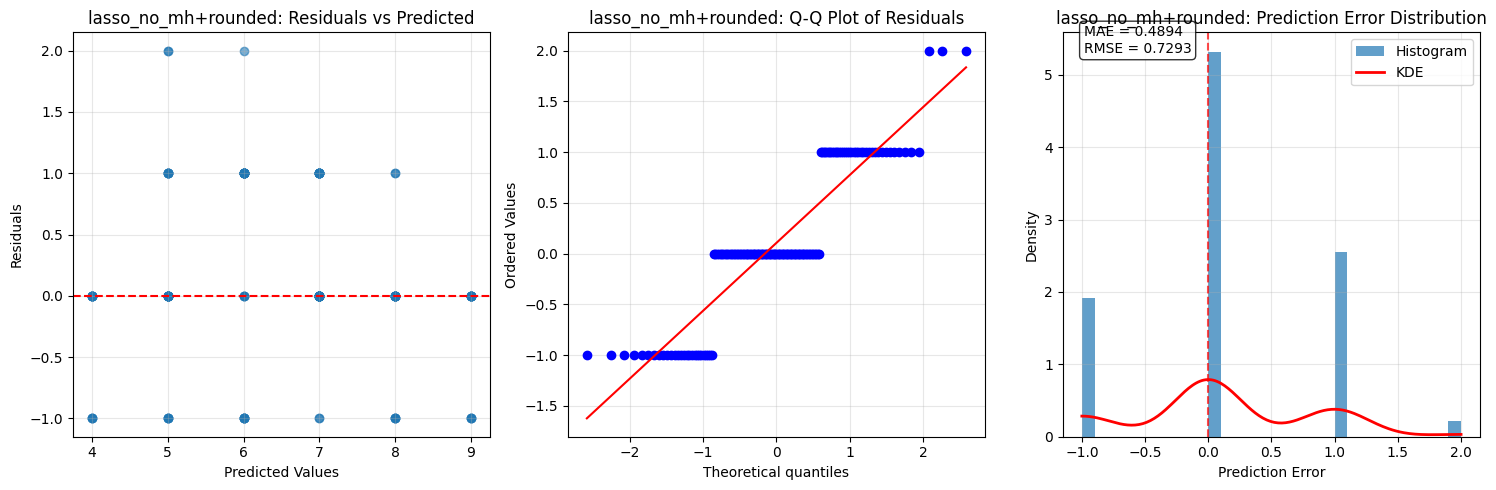

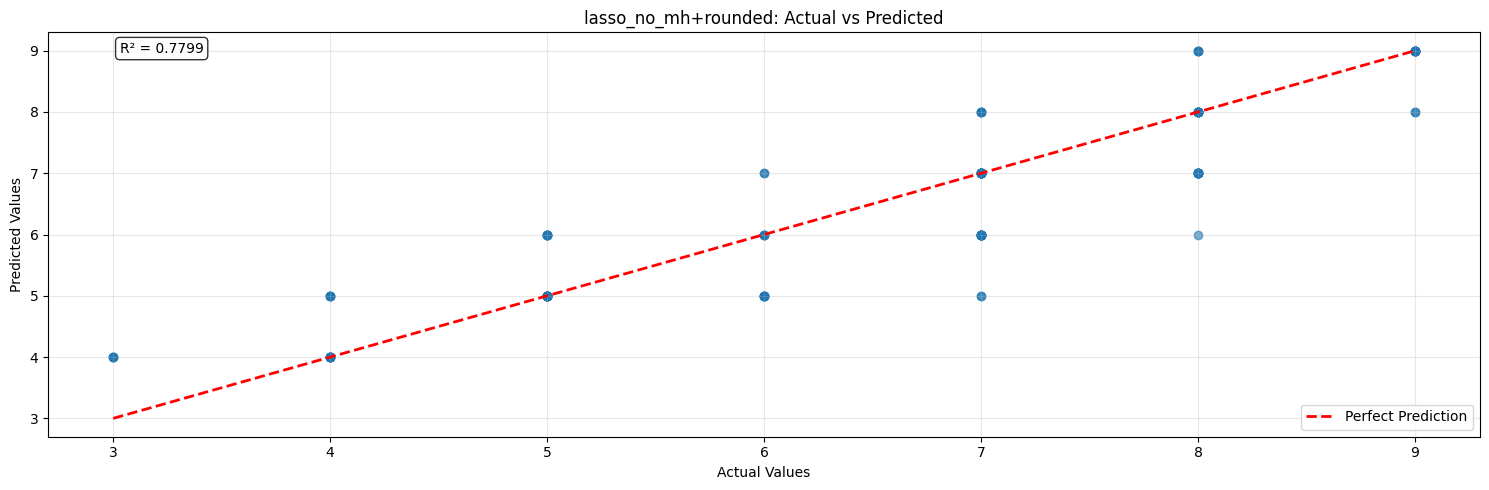

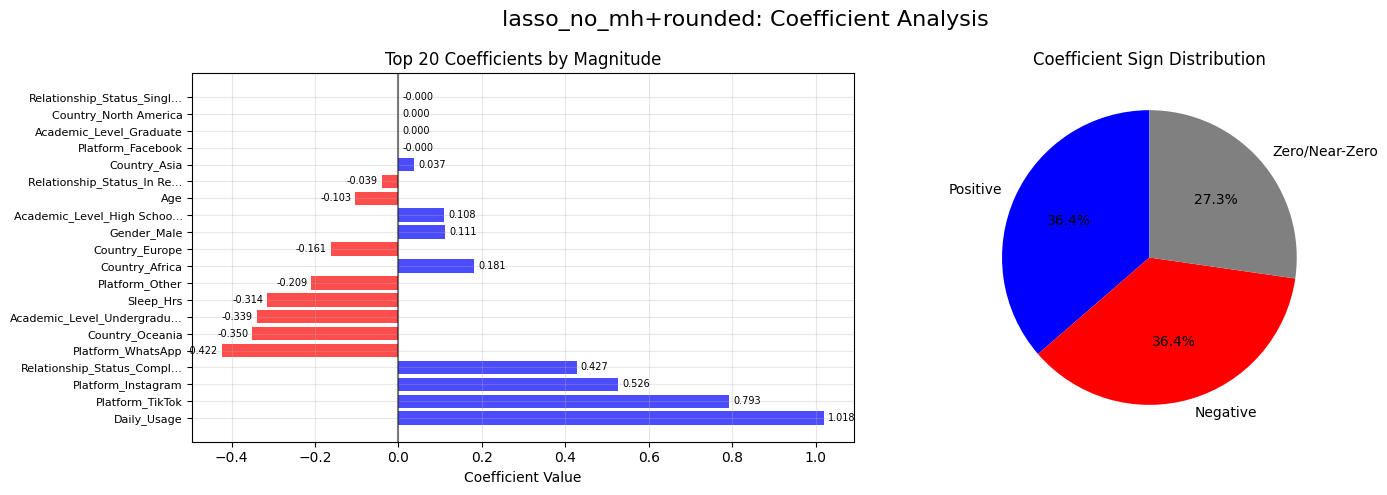

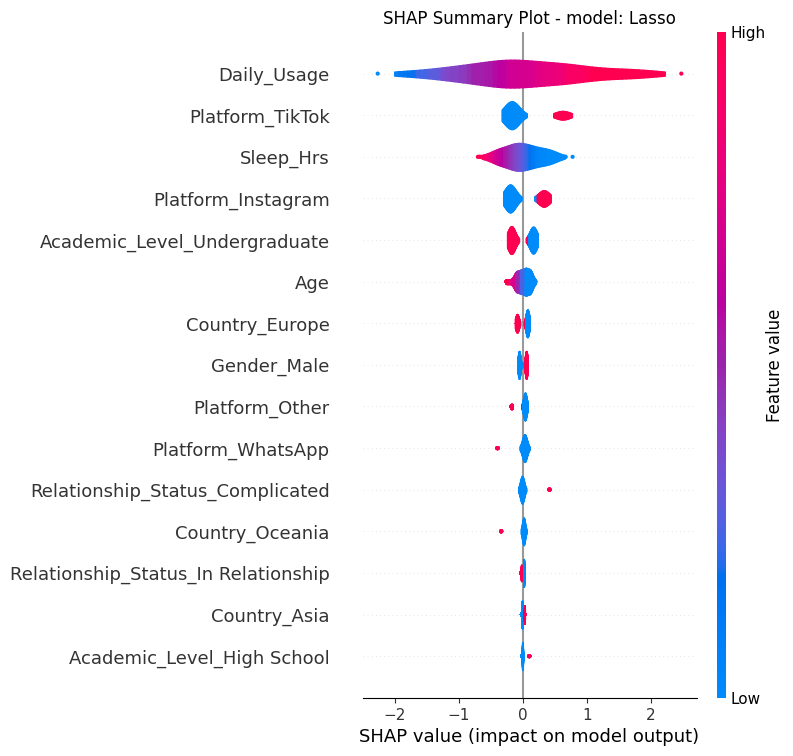

In [18]:
run_tags = ["all_features+rounded","no_mh+rounded"]

# Proper parameter grid for Lasso
param_grid_lasso = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [1000, 2000, 5000],
    'regressor__selection': ['cyclic', 'random'],
    'regressor__tol': [1e-4, 1e-3, 1e-2]
}
param_grid_lasso = { f'regressor__{k}': v for k, v in param_grid_lasso.items()}

figures = {}
# ===== Lasso experiments
for run_tag in run_tags:
    run_name = f"lasso_{run_tag}"

    if "no_mh" in run_tag:
        preprocessor_run = preprocessor_no_mh
    else:
        preprocessor_run = preprocessor

    # Create Lasso pipeline
    lasso_pipeline = Pipeline([
        ('preprocessing', preprocessor_run),
        ('regressor', RoundingRegressor(
            regressor=Lasso(random_state=42),
            min_value=3, 
            max_value=9
        ))
    ])


    # Run the grid search experiment with coefficient analysis
    best_lasso, test_results, *figures_lasso = run_regression_gridsearch_experiment(
        name=run_name,
        pipeline=lasso_pipeline,
        param_grid=param_grid_lasso,
        X_train=X_train_full, 
        y_train=y_train_full,
        X_test=X_test, 
        y_test=y_test,
        cv=cv,
        scoring=scoring,
        dataset=dataset,
        registered_model_name=f"addicted_score_lasso_{run_tag}",
        run_tag=run_tag,
        verbose=True,
        refit_metric="r2",
        linear=True  # This will show which features Lasso selected
    )

    figures[run_tag] = figures_lasso

    # ===== Log results
    # Append new row to existing dataframe instead of creating new one
    df_performance.loc[run_name] = {k: v for k, v in test_results.items() if k != 'predictions'}
    df_performance

# ===== Show coefficient, SHAP, and Prediction plots
for fig in figures['no_mh+rounded']:
    display(fig)



# XGBoost Regression Model

XGBoost (Extreme Gradient Boosting) is an advanced machine learning algorithm that uses gradient boosting to improve prediction accuracy. It is known for its ability to handle complex relationships in data and provide robust performance.

## Results
- **R²**: 0.87
- **RMSE**: 0.57
- **MAPE**: 0.05

## Top Features
- **Sleep Hours**
- **Daily Usage**
- **North America**
- **TikTok**

## SHAP Values
The SHAP analysis reveals the same important features as identified by Lasso regression, indicating consistency in feature importance across different models.

## Comparison with Lasso Regression
- **Performance**: XGBoost achieves a higher **R²** value (0.87) compared to Lasso (0.76), indicating better predictive performance.
- **Error Metrics**: XGBoost shows lower error metrics (MAE, MSE, RMSE, MAPE) compared to Lasso, suggesting improved accuracy.
- **Feature Importance**: Both models identify similar key features, with XGBoost adding "North America" as an important predictor.
- **Model Complexity**: XGBoost is more complex than Lasso but provides better performance, while Lasso offers better interpretability through feature selection.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
r2: 0.97 ± 0.01
MAE: -0.07 ± 0.02
MSE: -0.07 ± 0.02
RMSE: -0.26 ± 0.03
MAPE: -0.01 ± 0.0
Model type: tree
Model name: XGBRegressor
Tree SHAP plot type: violin


Registered model 'addicted_score_xgb_all_features+rounded' already exists. Creating a new version of this model...
Created version '4' of model 'addicted_score_xgb_all_features+rounded'.


Best parameters: {'regressor__regressor__colsample_bytree': 0.8, 'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__max_depth': 6, 'regressor__regressor__n_estimators': 200, 'regressor__regressor__reg_alpha': 0, 'regressor__regressor__reg_lambda': 1, 'regressor__regressor__subsample': 0.8}
Best R² score (CV): 0.97
Fitting 5 folds for each of 16 candidates, totalling 80 fits
r2: 0.87 ± 0.04
MAE: -0.26 ± 0.06
MSE: -0.33 ± 0.09
RMSE: -0.57 ± 0.08
MAPE: -0.05 ± 0.01
Model type: tree
Model name: XGBRegressor
Tree SHAP plot type: violin
Best parameters: {'regressor__regressor__colsample_bytree': 0.8, 'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__max_depth': 6, 'regressor__regressor__n_estimators': 100, 'regressor__regressor__reg_alpha': 1, 'regressor__regressor__reg_lambda': 1, 'regressor__regressor__subsample': 0.8}
Best R² score (CV): 0.87
XGBoost experiments completed!


Registered model 'addicted_score_xgb_no_mh+rounded' already exists. Creating a new version of this model...
Created version '12' of model 'addicted_score_xgb_no_mh+rounded'.


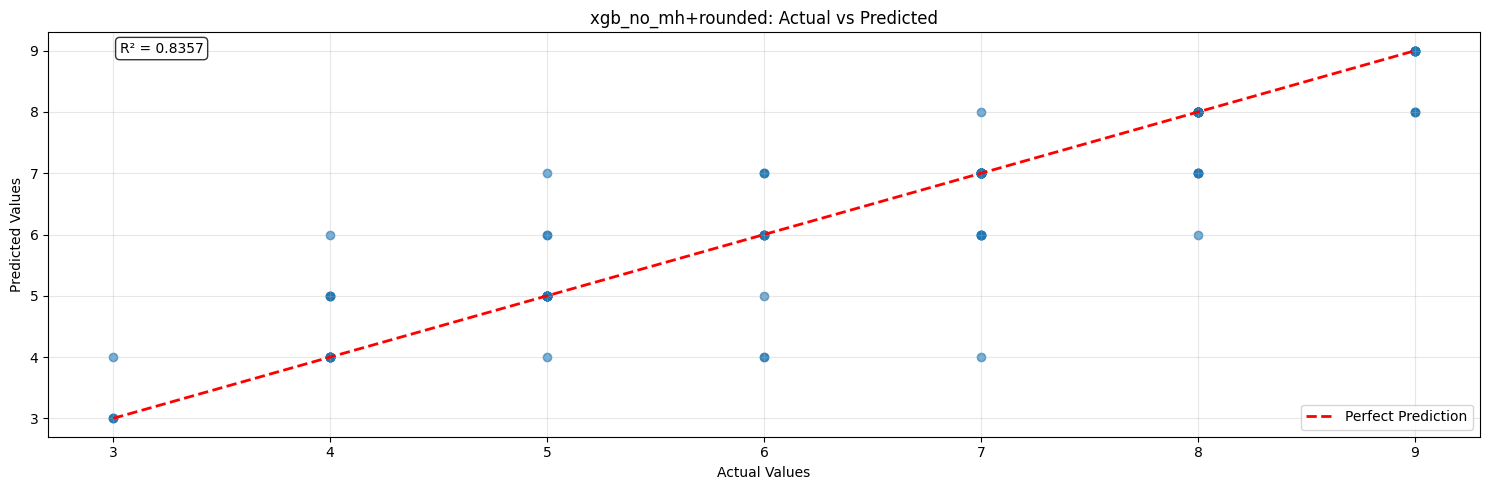

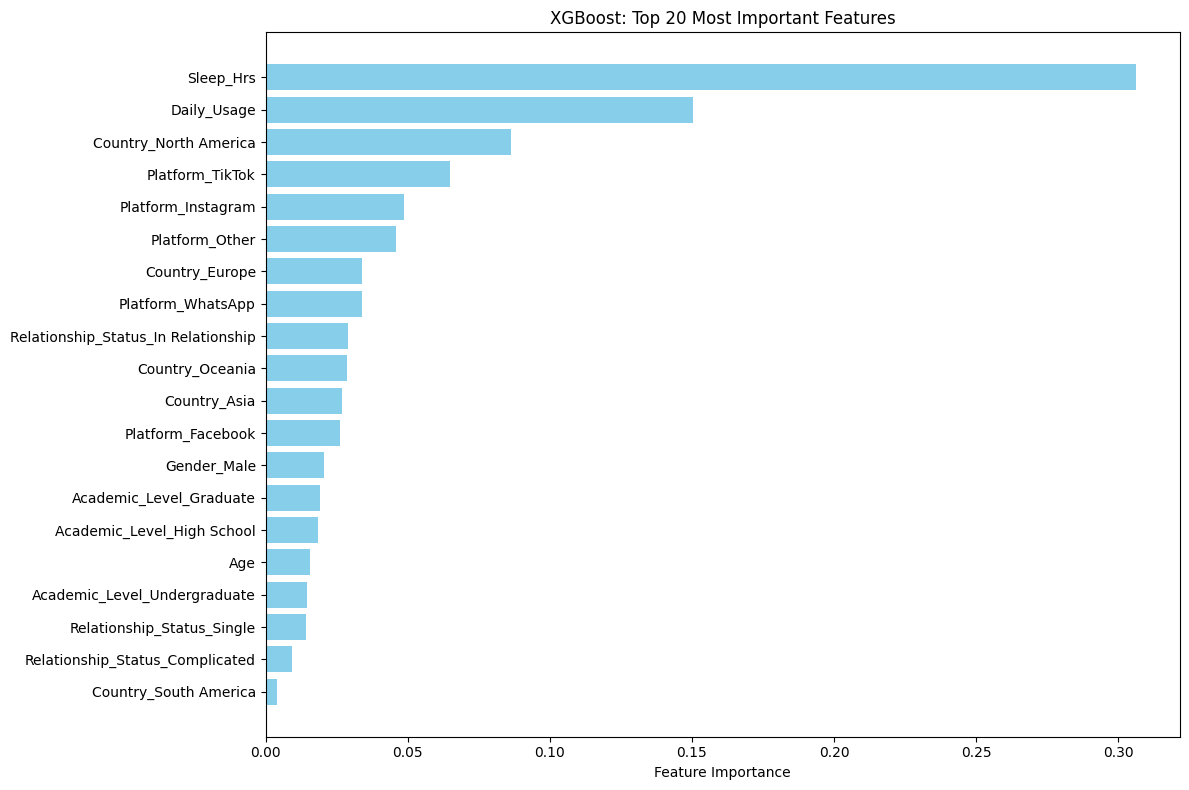

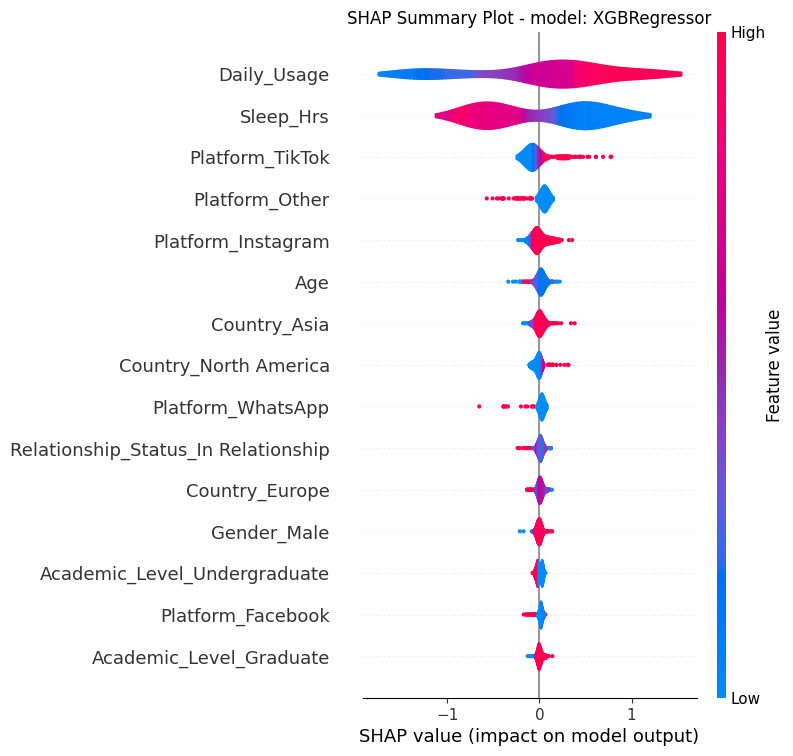

In [16]:

run_tags = ["all_features+rounded", "no_mh+rounded"]

# Compact parameter grid for XGBoost (faster search)
param_grid_xgb_compact = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [4, 6],
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__reg_alpha': [0, 1],
    'regressor__reg_lambda': [1]
}
param_grid_xgb_compact = {f'regressor__{k}': v for k, v in param_grid_xgb_compact.items()}

figures = {}
# ===== XGBoost experiments
for run_tag in run_tags:
    run_name = f"xgb_{run_tag}"

    if "no_mh" in run_tag:
        preprocessor_run = preprocessor_no_mh
    else:
        preprocessor_run = preprocessor

    # Create XGBoost pipeline
    xgb_pipeline = Pipeline([
        ('preprocessing', preprocessor_run),
        ('regressor', RoundingRegressor(
            XGBRegressor(random_state=42, n_jobs=-1), 
            min_value=3, max_value=9)
        )
    ])

    # Run the grid search experiment
    best_xgb, test_results, *figures_xgb = run_regression_gridsearch_experiment(
        name=run_name,
        pipeline=xgb_pipeline,
        param_grid=param_grid_xgb_compact,
        X_train=X_train_full, 
        y_train=y_train_full,
        X_test=X_test, 
        y_test=y_test,
        cv=cv,
        scoring=scoring,
        dataset=dataset,
        registered_model_name=f"addicted_score_xgb_{run_tag}",
        verbose=True,
        run_tag=run_tag,
        refit_metric="r2"
    )

    figures[run_tag] = figures_xgb

    # ===== Log results
    # Append new row to existing dataframe instead of creating new one
    df_performance.loc[run_name] = {k: v for k, v in test_results.items() if k != 'predictions'}
    df_performance

print("XGBoost experiments completed!")

# ===== Show SHAP and Prediction plots
for fig in figures['no_mh+rounded']:
    display(fig)

# CatBoost Regression Model

CatBoost is an advanced gradient boosting algorithm that excels in handling categorical features and often provides superior predictive performance compared to linear models. It is designed to reduce overfitting and improve generalization.

## Results
- **R²**: 0.91
- **RMSE**: 0.47
- **MAPE**: 0.04

## SHAP Values
The SHAP analysis identifies the following important features:
- **Daily Usage**
- **Sleep Hours**
- **Country**
- **Platform**

## Comparison with XGBoost
- **Performance**: CatBoost achieves a higher **R²** value (0.91) compared to XGBoost (0.87), indicating superior predictive performance.
- **Error Metrics**: CatBoost shows lower **RMSE** (0.47) and **MAPE** (0.04) compared to XGBoost, suggesting better accuracy.
- **Feature Importance**: Both models identify similar key features, with CatBoost emphasizing "Country" and "Platform" as important predictors.
- **Model Robustness**: CatBoost's ability to handle categorical features more effectively may contribute to its improved performance over XGBoost.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
r2: 0.98 ± 0.0
MAE: -0.06 ± 0.01
MSE: -0.06 ± 0.01
RMSE: -0.23 ± 0.03
MAPE: -0.01 ± 0.0
Model type: tree
Model name: CatBoostRegressor
CatBoost SHAP plot type: bar


Registered model 'addicted_score_catboost_all_features+rounded' already exists. Creating a new version of this model...
Created version '5' of model 'addicted_score_catboost_all_features+rounded'.


Best parameters: {'regressor__regressor__depth': 6, 'regressor__regressor__iterations': 300, 'regressor__regressor__learning_rate': 0.1}
Best R² score (CV): 0.98
Fitting 5 folds for each of 27 candidates, totalling 135 fits
r2: 0.91 ± 0.02
MAE: -0.2 ± 0.05
MSE: -0.22 ± 0.06
RMSE: -0.47 ± 0.06
MAPE: -0.04 ± 0.01
Model type: tree
Model name: CatBoostRegressor
CatBoost SHAP plot type: bar
Best parameters: {'regressor__regressor__depth': 8, 'regressor__regressor__iterations': 300, 'regressor__regressor__learning_rate': 0.2}
Best R² score (CV): 0.91
CatBoost experiments completed!


Registered model 'addicted_score_catboost_no_mh+rounded' already exists. Creating a new version of this model...
Created version '15' of model 'addicted_score_catboost_no_mh+rounded'.


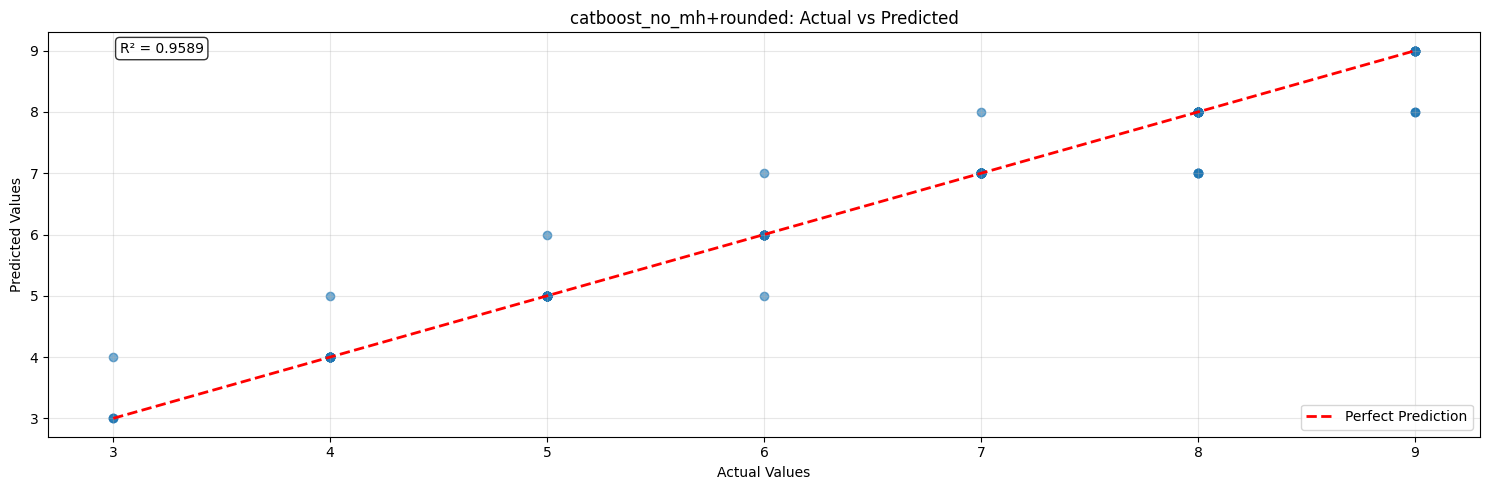

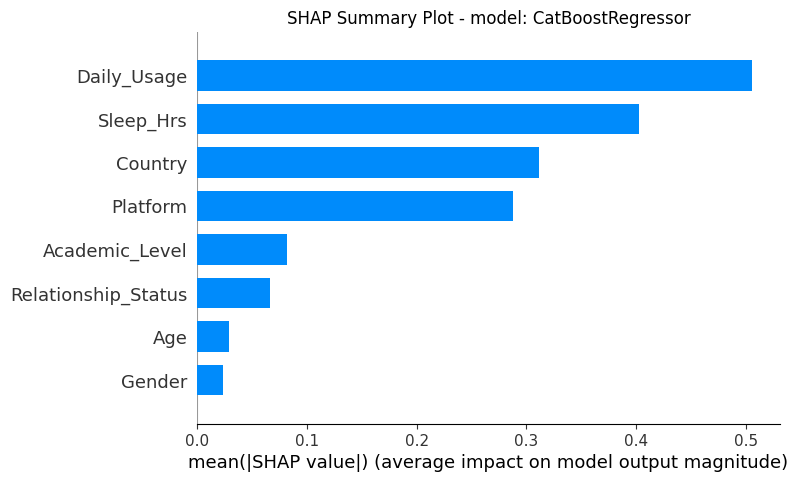

In [17]:
run_tags = ["all_features+rounded", "no_mh+rounded"]

# Create CatBoost regression pipeline components
categorical_features = binary_cats + low_card_cols + high_card_cols + country_col

param_grid_catboost = {
    'regressor__iterations': [100, 200, 300],
    'regressor__learning_rate': [0.03, 0.1, 0.2],
    'regressor__depth': [4, 6, 8]
}
param_grid_catboost = {f'regressor__{k}': v for k, v in param_grid_catboost.items()}

figures = {}
# ===== CatBoost experiments
for run_tag in run_tags:
    run_name = f"catboost_{run_tag}"

    if "no_mh" in run_tag:
        numeric_cols_run = numeric_cols_no_mh
    else:
        numeric_cols_run = numeric_cols

    # Create preprocessor for CatBoost
    preprocessor_catboost = ColumnTransformer([
        ('cats', 'passthrough', categorical_features),
        ('nums', numeric_transformer, numeric_cols_run),
    ], remainder='drop')

    # Create CatBoost pipeline
    catboost_pipeline = Pipeline([
        ('preprocessing', preprocessor_catboost),
        ('regressor', RoundingRegressor(            
            CatBoostRegressor(
                cat_features=list(range(len(categorical_features))),
                random_state=random_state,
                verbose=False,
                iterations=100),
            min_value=3, max_value=9)
        )
    ])

    # Run the grid search experiment
    best_catboost, test_results, *figures_catboost = run_regression_gridsearch_experiment(
        name=run_name,
        pipeline=catboost_pipeline,
        param_grid=param_grid_catboost,
        X_train=X_train_full, 
        y_train=y_train_full,
        X_test=X_test, 
        y_test=y_test,
        cv=cv,
        scoring=scoring,
        dataset=dataset,
        registered_model_name=f"addicted_score_catboost_{run_tag}",
        run_tag=run_tag,
        verbose=True,
        refit_metric="r2",
        coeff_profile=False
    )

    figures[run_tag] = figures_catboost

    # ===== Log results
    # Append new row to existing dataframe instead of creating new one
    df_performance.loc[run_name] = {k: v for k, v in test_results.items() if k != 'predictions'}
    df_performance

print("CatBoost experiments completed!")

# ===== Show SHAP and Prediction plots
for fig in figures['no_mh+rounded']:
    display(fig)


# Conclusion

## Model Performance Summary
Our regression analysis demonstrates that **CatBoost** emerges as the top-performing model with the highest **R²** (0.91) and lowest error metrics (RMSE: 0.47, MAPE: 0.04), followed closely by **XGBoost** (R²: 0.87). Both gradient boosting models significantly outperform linear approaches, indicating the presence of non-linear relationships in the data.

## Key Predictive Features
Across all models, **daily usage** and **sleep hours** consistently emerge as the most important predictors of social media addiction scores. **TikTok usage** and **mental health** also show strong predictive power, though the latter introduces potential bias concerns.

## Mental Health Feature Impact
The inclusion/exclusion of the mental health feature reveals important trade-offs:
- **With mental health**: Models achieve higher performance (R²: 0.93 for linear regression) but may suffer from self-reporting bias
- **Without mental health**: Performance decreases for lasso (R²: 0.76) while still satisifactory for CatBoost (R²: 0.91), but provides more objective predictions based on behavioral patterns

## Model Selection Recommendations
For **maximum accuracy**: Use CatBoost or XGBoost with all features
For **interpretability and bias reduction**: Use Lasso regression without mental health features
For **balanced approach**: Consider XGBoost without mental health for good performance while avoiding potential bias

The analysis suggests that behavioral features (usage patterns, sleep) combined with demographic factors provide robust predictors of social media addiction, with gradient boosting methods capturing complex feature interactions most effectively.